In [2]:
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract Pillow opencv-python-headless

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import os
import cv2
import json
import shutil
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
import pytesseract
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout

In [7]:
def adjust_brightness_for_tritanopia(image, hue_shift, brightness_factor):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:, :, 0] = (hsv[:, :, 0] + hue_shift) % 180
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness_factor, 0, 255)
    modified_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return modified_image

def generate_and_show_images(original_images_dir, bg_names, rv_names):
    id = 39
    for filename in os.listdir(original_images_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(original_images_dir, filename)
            original_image = cv2.imread(image_path)

            number = int(filename.split('_')[1].split('.')[0])

            if number in bg_names:
                hue_shift = 55
                brightness_factor = 1.2
            elif number in rv_names:
                hue_shift = 150
                brightness_factor = 1.5
            else:
                continue

            modified_image_tritanopia = adjust_brightness_for_tritanopia(original_image, hue_shift, brightness_factor)
            save_path_tritanopia = os.path.join(r'C:\Users\Michelle\Desktop\dt', filename.split('_')[0]+'_'+str(id)+'.jpg')
            cv2.imwrite(save_path_tritanopia, modified_image_tritanopia)

            id += 1


save_dirs = r'C:\Users\Michelle\Desktop\dt'
if not os.path.exists(save_dirs):
    os.makedirs(save_dirs)

bg_names = [10, 11, 12, 13, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38]
rv_names = [1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21]
original_images_dir = r'C:\Users\Michelle\Desktop\dt'

generate_and_show_images(original_images_dir, bg_names, rv_names)


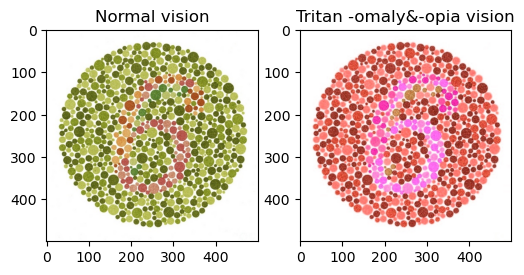

In [19]:
pic_origin = cv2.imread(os.path.join(original_images_dir, 'Ishihara_03.jpg'))
pic_modified = cv2.imread(os.path.join(original_images_dir, 'Ishihara_41.jpg'))

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(cv2.cvtColor(pic_origin, cv2.COLOR_BGR2RGB))
axs[0].set_title('Normal vision')

axs[1].imshow(cv2.cvtColor(pic_modified, cv2.COLOR_BGR2RGB))
axs[1].set_title('Tritan -omaly&-opia vision')
plt.show()

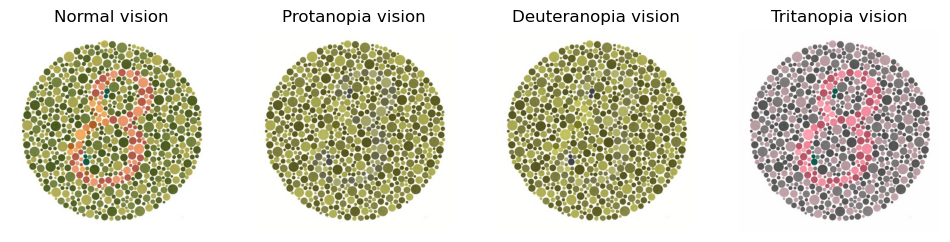

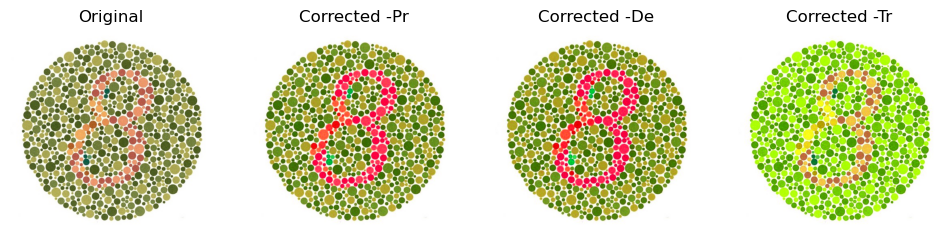

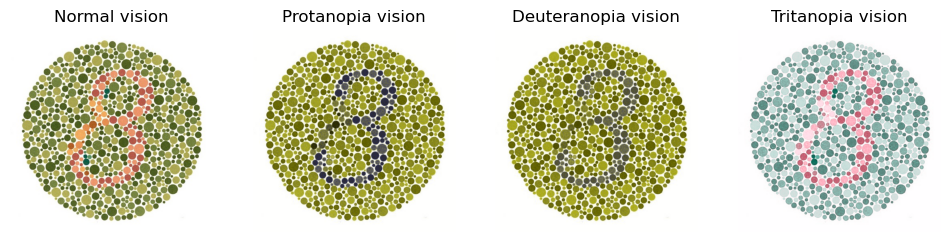

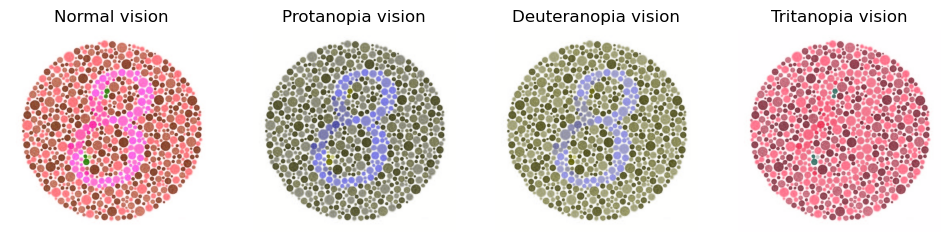

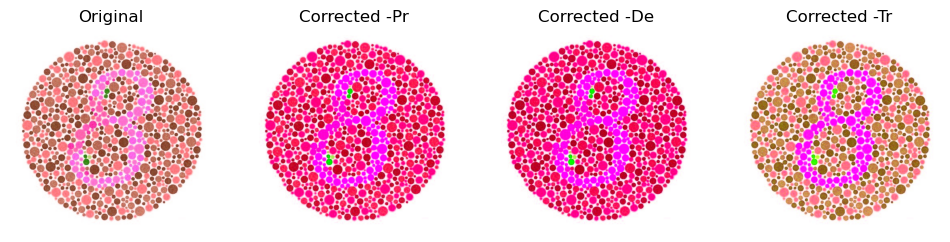

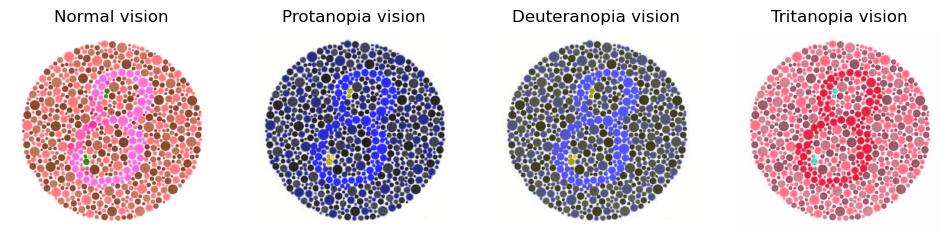

In [43]:

# LMS transformation matrices
RGB_to_LMS = np.array([[0.31399022, 0.63951294, 0.04649755],
                       [0.15537241, 0.75789446, 0.08670142],
                       [0.01775239, 0.10944209, 0.87256922]])

# Simulative daltonism matrices
LMS_to_Protanopia = np.array([[0, 1.05118294, -0.05116099],
                              [0, 1, 0],
                              [0, 0, 1]])

LMS_to_Deuteranopia = np.array([[1, 0, 0],
                                [0.9513092, 0, 0.04866992],
                                [0, 0, 1]])

LMS_to_Tritanopia = np.array([[1, 0, 0],
                              [0, 1, 0],
                              [0.05, 0.95, 0]])

# LMS to RGB transformation matrix
LMS_to_RGB = np.array([[5.47221206, -4.6419601, 0.16963708],
                       [-1.1252419, 2.29317094, -0.1678952],
                       [0.02980165, -0.19318073, 1.16364789]])


# Color matrices for colorblindness
protanopia_matrix = np.array([[0.56667, 0.43333, 0],
                              [0.55833, 0.44167, 0],
                              [0, 0.24167, 0.75833]])

deuteranopia_matrix = np.array([[0.625, 0.375, 0],
                                [0.7, 0.3, 0],
                                [0, 0.3, 0.7]])

tritanopia_matrix = np.array([[0.95, 0.05, 0],
                              [0, 0.43333, 0.56667],
                              [0, 0.475, 0.525]])

def simulate_color_vision_deficiency(image, deficiency_type):
    """Simulate color vision deficiency on an image."""
    img = image.convert('RGB')
    img_np = np.array(img) / 255.0

    lms_img = np.dot(img_np, RGB_to_LMS.T)

    # Apply the appropriate LMS to deficiency transformation
    if deficiency_type == 'protanopia':
        deficiency_img = np.dot(lms_img, LMS_to_Protanopia.T)
    elif deficiency_type == 'deuteranopia':
        deficiency_img = np.dot(lms_img, LMS_to_Deuteranopia.T)
    elif deficiency_type == 'tritanopia':
        deficiency_img = np.dot(lms_img, LMS_to_Tritanopia.T)
    else:
        raise ValueError("Unknown deficiency type")

    rgb_img = np.dot(deficiency_img, LMS_to_RGB.T)
    rgb_img = np.clip(rgb_img, 0, 1)

    final_img = Image.fromarray((rgb_img * 255).astype('uint8'), 'RGB')
    return final_img


def simulate_colorblindness(image, matrix):
    """Simulate colorblindness on an image using the given matrix."""
    image_np = np.array(image)
    if image_np.ndim == 3 and image_np.shape[2] == 3:
        simulated_image_np = cv2.transform(image_np, matrix)
        simulated_image = Image.fromarray(np.uint8(simulated_image_np))
        return simulated_image
    else:
        print("Image is not in the expected format (3 channels).")
        return None

def correct_colorblindness(image, matrix):
    """Correct colorblindness on an image using the given matrix."""
    image_np = np.array(image) / 255.0
    if image_np.ndim == 3 and image_np.shape[2] == 3:
        
        # Simulate the colorblind image
        simulated_image_np = cv2.transform(image_np, matrix)

        error = image_np - simulated_image_np

        corrected_image_np = image_np + error * 2

        corrected_image_np = np.clip(corrected_image_np, 0, 1) * 255
        corrected_image = Image.fromarray(np.uint8(corrected_image_np))
        return corrected_image
    else:
        print("Image is not in the expected format (3 channels).")
        return None

    
def save_images(image, images, sp, fn):
    """Save the images into respective directories."""
    plate = int(fn.split('_')[1].split('.')[0])
    if plate <= 38:
        cv2.imwrite(f'{sp+main_fldrs[0]+fldrs[0]}\\{fn}', image)
        cv2.imwrite(f'{sp+main_fldrs[0]+fldrs[1]}\\{fn}', image)
        cv2.imwrite(f'{sp+main_fldrs[1]+fldrs[0]}\\Pr_{fn}', np.array(images[1])[:, :, ::-1])
        cv2.imwrite(f'{sp+main_fldrs[1]+fldrs[1]}\\De_{fn}', np.array(images[2])[:, :, ::-1])
    else:
        data = np.array(images[3])[:, :, ::-1]
        cv2.imwrite(f'{sp+main_fldrs[0]+fldrs[2]}\\Tr_{fn}', image)
        cv2.imwrite(f'{sp+main_fldrs[1]+fldrs[2]}\\Tr_{fn}', np.array(images[3])[:, :, ::-1])

        
def display_images(images, titles, fn):
    """Display a list of images with titles."""
    plate = int(fn.split('_')[1].split('.')[0])
    if plate == 2 or plate == 40:
        plt.figure(figsize=(12, 6))
        for i, (im, title) in enumerate(zip(images, titles)):
            plt.subplot(1, 4, i + 1)
            plt.imshow(im)
            plt.title(title)
            plt.axis('off')
        plt.show()

source_dir = r'C:\Users\Michelle\Desktop\dt'


main_fldrs = ['\\original', '\\adjusted']
fldrs = ['\\protanopia', '\\deuteranopia', '\\tritanopia']
for name in main_fldrs:
    if not os.path.exists(source_dir + name):
        os.makedirs(source_dir + name)
    for f in fldrs:
        if not os.path.exists(source_dir + name + f):
            os.makedirs(source_dir + name + f)

            
for i, image_name in enumerate(os.listdir(source_dir)):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(source_dir, image_name)
        image = Image.open(image_path)

        # Simulate colorblindness
        protanopia_image = simulate_color_vision_deficiency(image, 'protanopia')
        deuteranopia_image = simulate_color_vision_deficiency(image, 'deuteranopia')
        tritanopia_image = simulate_color_vision_deficiency(image, 'tritanopia')

        # Correct images
        corrected_protanopia_image = correct_colorblindness(image, protanopia_matrix)
        corrected_deuteranopia_image = correct_colorblindness(image, deuteranopia_matrix)
        corrected_tritanopia_image = correct_colorblindness(image, tritanopia_matrix)

        protanopia_img = simulate_color_vision_deficiency(corrected_protanopia_image, 'protanopia')
        deuteranopia_img = simulate_color_vision_deficiency(corrected_deuteranopia_image, 'deuteranopia')
        tritanopia_img = simulate_color_vision_deficiency(corrected_tritanopia_image, 'tritanopia')

        # Display original and colorblindness simulated images
        images = [image, protanopia_image, deuteranopia_image, tritanopia_image]
        titles = ['Normal vision', 'Protanopia vision', 'Deuteranopia vision', 'Tritanopia vision']
        display_images(images, titles, image_name)

        # Display original and corrected images
        corrected_images = [image, corrected_protanopia_image, corrected_deuteranopia_image, corrected_tritanopia_image]
        corrected_titles = ['Original', 'Corrected -Pr', 'Corrected -De', 'Corrected -Tr']
        display_images(corrected_images, corrected_titles, image_name)

        # Save corrected images
        original_img = np.array(image)[:, :, ::-1]
        save_images(original_img, corrected_images, source_dir, image_name)

        resimulated_images = [image, protanopia_img, deuteranopia_img, tritanopia_img]
        resimulated_titles = ['Normal vision', 'Protanopia vision', 'Deuteranopia vision', 'Tritanopia vision']
        display_images(resimulated_images, resimulated_titles, image_name)


In [25]:
cls = ['protanopia', 'deuteranopia', 'tritanopia']

original = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    validation_split=0.1)

origX_train = original.flow_from_directory(
    directory=r'C:\Users\Michelle\Desktop\dt\original',
    target_size=(256, 256),
    classes=cls,
    class_mode=None,
    batch_size=32,
    subset='training',
    shuffle=False)

origX_val = original.flow_from_directory(
    directory=r'C:\Users\Michelle\Desktop\dt\original',
    target_size=(256, 256),
    classes=cls,
    class_mode=None,
    batch_size=32,
    subset='validation',
    shuffle=False)

adjusted = tf.keras.preprocessing.image.ImageDataGenerator( 
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255,
    validation_split=0.1)

adjY_train = adjusted.flow_from_directory(
    directory=r'C:\Users\Michelle\Desktop\dt\adjusted',
    target_size=(256, 256),
    classes=cls,
    class_mode=None,
    batch_size=32,
    subset='training',
    shuffle=False)

adjY_val = adjusted.flow_from_directory(
    directory=r'C:\Users\Michelle\Desktop\dt\adjusted',
    target_size=(256, 256),
    classes=cls,
    class_mode=None,
    batch_size=32,
    subset='validation',
    shuffle=False)

Found 103 images belonging to 3 classes.
Found 9 images belonging to 3 classes.
Found 103 images belonging to 3 classes.
Found 9 images belonging to 3 classes.


In [26]:
def shaping(lst1, lst2, num_batches=10):
    c = 0
    for dt in lst2:
        images = []
        batches = min(num_batches, len(dt))
        for _ in range(batches):
            batch = next(dt)
            for img in batch:
                images.append(img)
        lst1[c] = np.array(images)
        c += 1
    return lst1

X_train, x_test, Y_train, y_test = shaping(
    lst1=[[], [], [], []], 
    lst2=[origX_train, origX_val, adjY_train, adjY_val],
    num_batches=10
)


X_train.shape, x_test.shape, Y_train.shape, y_test.shape

((103, 256, 256, 3), (9, 256, 256, 3), (103, 256, 256, 3), (9, 256, 256, 3))

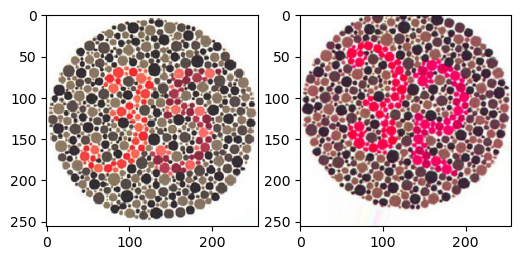

In [28]:
figure,axis = plt.subplots(1, 2, figsize=(6,3))

axis[0].imshow(X_train[55])

axis[1].imshow(Y_train[55])

In [32]:
enc = Sequential()

enc.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
enc.add(MaxPooling2D((2, 2), padding='same'))
enc.add(Dropout(0.2))
enc.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
enc.add(MaxPooling2D((2, 2), padding='same'))
enc.add(Dropout(0.2))
enc.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
enc.add(MaxPooling2D((2, 2), padding='same'))
enc.add(Dropout(0.2))
enc.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
enc.add(MaxPooling2D((2, 2), padding='same'))

dec = Sequential()

dec.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
dec.add(UpSampling2D((2, 2)))
dec.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
dec.add(UpSampling2D((2, 2)))
dec.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
dec.add(UpSampling2D((2, 2)))
dec.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
dec.add(UpSampling2D((2, 2)))
dec.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same', kernel_initializer='glorot_uniform'))

auto = Sequential([enc, dec])
auto.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'], loss='mse')


In [33]:
history = auto.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=16,
    shuffle=True,
    validation_data=(x_test, y_test)
)

Epoch 1/20
7/7 [==============================] - 28s 4s/step - loss: 0.1231 - accuracy: 0.5574 - val_loss: 0.1111 - val_accuracy: 0.5045
Epoch 2/20
7/7 [==============================] - 27s 3s/step - loss: 0.0942 - accuracy: 0.5932 - val_loss: 0.1004 - val_accuracy: 0.5774
Epoch 3/20
7/7 [==============================] - 19s 3s/step - loss: 0.0869 - accuracy: 0.6082 - val_loss: 0.0887 - val_accuracy: 0.5326
Epoch 4/20
7/7 [==============================] - 20s 3s/step - loss: 0.0833 - accuracy: 0.5295 - val_loss: 0.0926 - val_accuracy: 0.5355
Epoch 5/20
7/7 [==============================] - 19s 3s/step - loss: 0.0785 - accuracy: 0.5632 - val_loss: 0.0898 - val_accuracy: 0.5326
Epoch 6/20
7/7 [==============================] - 20s 3s/step - loss: 0.0771 - accuracy: 0.5233 - val_loss: 0.0794 - val_accuracy: 0.5130
Epoch 7/20
7/7 [==============================] - 19s 3s/step - loss: 0.0771 - accuracy: 0.5846 - val_loss: 0.0714 - val_accuracy: 0.5761
Epoch 8/20
7/7 [==================

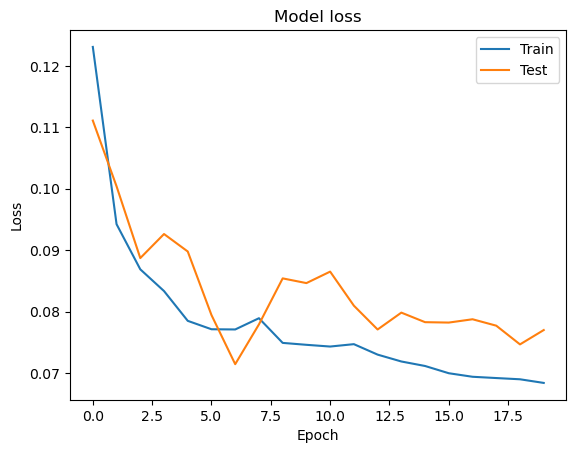

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [35]:
# Оценка модели на тестовом наборе
loss = auto.evaluate(x_test, y_test, batch_size=32)
print(f"Test loss: {loss}")


1/1 [==============================] - 0s 463ms/step - loss: 0.0770 - accuracy: 0.6246
Test loss: [0.07699832320213318, 0.6245998740196228]


1/1 [==============================] - 0s 434ms/step


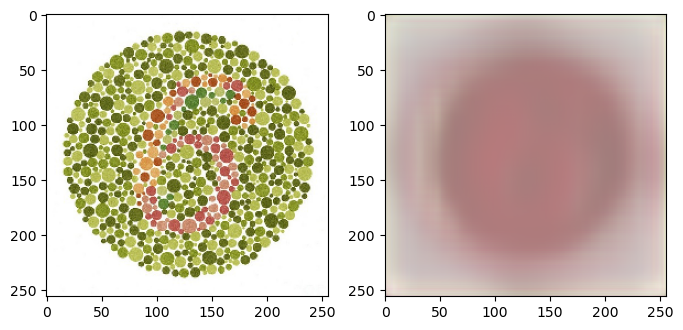

In [39]:
res = auto.predict(x_test)

figure,axis = plt.subplots(1, 2, figsize=(8,8))

axis[0].imshow(x_test[2])

axis[1].imshow(res[2])